In [1]:
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

from sklearn.metrics import classification_report
from sklearn.utils import shuffle

# Loading Data:
---

Since scikit-learn has a SVM class already set up we will try training that on our data. Unfortunately, sklearn doesn't have an easy way to do lazy loading. This means we need to load all of the data onto memory, which means that the number of images we can use is even further limited by the available RAM on our computers/on Colab.

In the cell below I only load 1500 edible and 450 poisonous images because Colab crashes if I try to load more. I decided on this split because it relflects the fact that in practice the model would be seeing far more non-poisonous mushrooms than poisonous. I've also reduced the size of the images in order to load more of them. This may impact the performance of the model.



In [2]:
#@markdown ### Set image dimensions and color channels
img_height = 128 #@param {type:"number"}
img_width = 128 #@param {type:"number"}
color_channels = 3 #@param {type:"number"}

In [9]:
def make_dataset(data_dir):
  categories = ['edible', 'poisonous']
  flat_data = []
  targets = []
  for category in categories:
    print(f'loading... category : {category}')
    path = os.path.join(data_dir, category)

    # limit number of images to load
    slice_num = 1500
    for i, img in enumerate(os.listdir(path)):
      if category == 'edible':
        if i > slice_num:
            break
      elif category == 'poisonous':
        edible = os.path.join(data_dir, 'edible')
        if i > len(os.listdir(edible)) * .3 or i > slice_num * .3:
          break

      if i % 100 == 0:
        print(f'processing image {i}/{len(os.listdir(path))}')

      img_array = imread(os.path.join(path,img))
      img_resized = resize(img_array, (img_height, img_width, color_channels))
      flat_data.append(img_resized.flatten())
      targets.append(categories.index(category))

    print(f'successfully loaded {category} images')

  y = pd.Series(targets)
  x = pd.DataFrame(flat_data)
  return x,y

In [10]:
x_train, y_train = make_dataset('/content/drive/MyDrive/Data_Science_Course/Capstones/Capstone_4/data/train/')
x_test, y_test = make_dataset('/content/drive/MyDrive/Data_Science_Course/Capstones/Capstone_4/data/test/')

loading... category : edible
processing image 0/2480
processing image 100/2480
processing image 200/2480
processing image 300/2480
processing image 400/2480
processing image 500/2480
processing image 600/2480
processing image 700/2480
processing image 800/2480
processing image 900/2480
processing image 1000/2480
processing image 1100/2480
processing image 1200/2480
processing image 1300/2480
processing image 1400/2480
processing image 1500/2480
successfully loaded edible images
loading... category : poisonous
processing image 0/1778
processing image 100/1778
processing image 200/1778
processing image 300/1778
processing image 400/1778
successfully loaded poisonous images
loading... category : edible
processing image 0/310
processing image 100/310
processing image 200/310
processing image 300/310
successfully loaded edible images
loading... category : poisonous
processing image 0/224
successfully loaded poisonous images


# Creating SVM Baseline Model:
---

In [66]:
clf = make_pipeline(StandardScaler(), SVC(probability=True, class_weight='balanced'))

In [67]:
clf.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(class_weight='balanced', probability=True))])

In [68]:
y_pred = clf.predict(x_test)
print('Model accuracy: ', accuracy_score(y_pred,y_test)*100, '%')

Model accuracy:  71.53465346534654 %


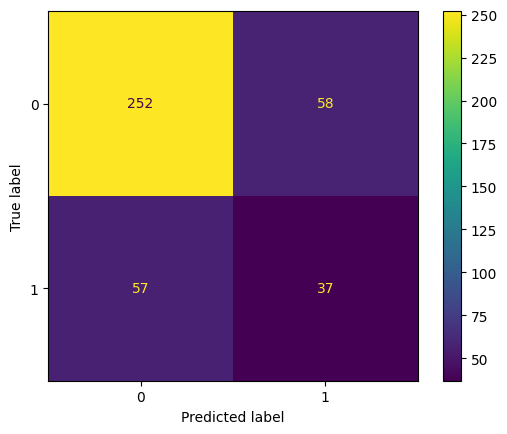

In [69]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

With the very limited amount of data available to this model, it didn't perform very well. While it achieved 70% accuracy, it incorrectly classified 60% of the poisonous images as edible.

As with the CNN, I'll see if we can improve this model's performance by using transfer learning.

# Creating Transfer Learning Pipeline:
---

In [4]:
model = MobileNet(input_shape=(img_height, img_width, color_channels), include_top=True)
model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32) 

The output of `reshape_2` layer is a 1,000 element vector that is the input for MobileNet's prediction layer. This is the what I'll use for classification with the SVM.

In [5]:
vector = model.get_layer("reshape_2").output
feature_extractor = tf.keras.Model(model.input, vector)

In [11]:
def make_transfer_learning_ds(data_dir):
  # create empty feature and label lists
  data = []
  categories = ['edible', 'poisonous']
  slice_num = 1500

  for category in categories:
    print(f'loading... category : {category}')
    path = os.path.join(data_dir, category)

    for i, img in enumerate(os.listdir(path)):

      # limit number of images to load
      if category == 'edible':
        if i > slice_num:
            break

      elif category == 'poisonous':
        edible = os.path.join(data_dir, 'edible')
        if i > len(os.listdir(edible)) * .3 or i > slice_num * .3:
          break

      if i % 100 == 0:
        print(f'processing image {i}/{len(os.listdir(path))}')

      file_path = os.path.join(path, img)

      # load image
      img = image.load_img(file_path, target_size=(img_height, img_width))
      img_arr = image.img_to_array(img)
      img_arr_b = np.expand_dims(img_arr, axis=0)

      # use builtin function to preprocess image
      input_img = preprocess_input(img_arr_b)

      # run image through the feature extractor
      feature_vec = feature_extractor.predict(input_img)

      data.append(feature_vec.ravel())
  return data

In [7]:
def process_data(x, y):
  x = np.asarray(x, dtype=np.float32)
  y = np.asarray(y, dtype=np.float32)

  for s in range(100):
      x, y = shuffle(x, y)
  return x, y


In [12]:
x_train_transfer = make_transfer_learning_ds('/content/drive/MyDrive/Data_Science_Course/Capstones/Capstone_4/data/train/')
x_test_transfer = make_transfer_learning_ds('/content/drive/MyDrive/Data_Science_Course/Capstones/Capstone_4/data/test/')

x_train_transfer, y_train_transfer = process_data(x_train_transfer, y_train)
x_test_transfer, y_test_transfer = process_data(x_test_transfer, y_test)

loading... category : edible
processing image 0/2480
1/1 [==============================] - 0s 59ms/step
processing image 100/2480
1/1 [==============================] - 0s 46ms/step
processing image 200/2480
1/1 [==============================] - 0s 45ms/step
processing image 300/2480
1/1 [==============================] - 0s 55ms/step
processing image 400/2480
1/1 [==============================] - 0s 42ms/step
processing image 500/2480
1/1 [==============================] - 0s 52ms/step
processing image 600/2480
1/1 [==============================] - 0s 46ms/step
processing image 700/2480
1/1 [==============================] - 0s 44ms/step
processing image 800/2480
1/1 [==============================] - 0s 46ms/step
processing image 900/2480
1/1 [==============================] - 0s 45ms/step
processing image 1000/2480
1/1 [==============================] - 0s 49ms/step
processing image 1100/2480
1/1 [==============================] - 0s 44ms/step
processing image 1200/2480
1/1 [===

In [13]:
svm = SVC(C=1, class_weight='balanced')
svm.fit(x_train_transfer, y_train_transfer)
y_pred_transfer = svm.predict(x_test_transfer)
classes = ['edible', 'poisonous']
print(classification_report(y_test_transfer, y_pred_transfer,
                            target_names=classes))

              precision    recall  f1-score   support

      edible       0.86      0.90      0.88       310
   poisonous       0.60      0.51      0.55        94

    accuracy                           0.81       404
   macro avg       0.73      0.70      0.71       404
weighted avg       0.80      0.81      0.80       404



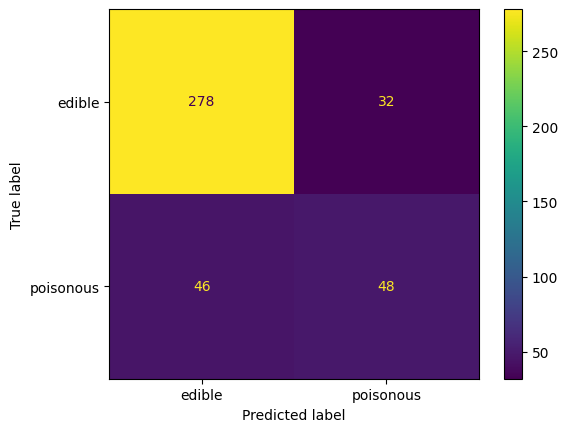

In [14]:
cm = confusion_matrix(y_test_transfer, y_pred_transfer, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot()
plt.show()

Using transfer learning improved the performance of the model across all metrics. Accuracy increased by 10%, and precision and recall increased for both classes.

# Next Steps for This Model:
---

Although the performance of this model is suboptimal, I believe it has potential as a nice solution to this problem. Rather than giving a user a prediction of "Edible" or "Poisonous", it could be really useful to give them the probability that the mushroom is either class and let them use the probabilities to inform their decision of whether or not to pick a mushroom.

Next steps for this model could include fine tuning the transfer learning model to try and improve performance. It could also be useful to build and train the model with TensorFlow so that we could use something like `image_dataset_from_directory` that creates a generator object rather than loading all of the data at once. This would allow the model to be trained on more data, which would almost certainly increase performance.

Another reason to use TensorFlow is that scikit-learn doesn't provide data augmentation functions and layers. For this reason, combined with the fact that reducing the availability of color as a feature would further reduce the ability of this model to function on such a small dataset, the low/bright light element was ignored for this model.  

# Resources:
---
https://www.kaggle.com/code/ozdemirh/flower-recognition-with-transfer-learning-and-svm
https://medium.com/analytics-vidhya/image-classification-using-machine-learning-support-vector-machine-svm-dc7a0ec92e01